In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from pklshop.data import *
from pklshop.stats import *
from pklshop.game import *
from pklshop.player import *

%load_ext autoreload
%autoreload 2

I'm curious what variables are most closely correlated with games won. Let's do some exploratory data analysis to find out.

In [2]:
rally = get_tab_as_df("rally")
players = get_tab_as_df("player")
game = get_tab_as_df("game")
team = get_tab_as_df("team")
match = get_tab_as_df("match")
tournament = get_tab_as_df("tournament") 
shots = get_tab_as_df("shot")
shot_type_ref = get_tab_as_df("shot_type_ref")

First let's determine some summary stats of each player, like the win rate, number of games played, and what type of 3rd shot they hit the most 

In [71]:
win_rate_arr = []
names = []
error_rates = []
# games_played = []
third_drop_frac = []
third_drive_frac = []
third_lob_frac = []
partner_win_rate = []
partner_error_rate = []
for i, player_id in enumerate(players.player_id):
    p = Player(player_id)
    #only look at players who have played at least 3 games in the database
    if p.num_games_played <3:
        continue
    names.append(p.name)
    win_rate_arr.append(p.num_games_won/p.num_games_played)
    error_rates.append(p.error_rate())
    # games_played.append(p.num_games_played)
    thirds = p.third_shot_profile()
    partner_win_rate.append(p.partners_win_rate())
    partner_error_rate.append(p.partners_error_rate())
    if thirds[3]!=0:
        third_drop_frac.append(thirds[0]/thirds[3])
        third_drive_frac.append(thirds[1]/thirds[3])
        third_lob_frac.append(thirds[2]/thirds[3])
    else:
        third_drop_frac.append(0)
        third_drive_frac.append(0)
        third_lob_frac.append(0)

In [72]:
summary_df = pd.DataFrame({"name": names, 
"win_rate": win_rate_arr, 
"error_rate": error_rates, 
"third_drop_frac": third_drop_frac,
 "third_drive_frac": third_drive_frac, 
 "third_lob_frac": third_lob_frac,
  "partner_win_rate": partner_win_rate, 
  "partner_error_rate": partner_error_rate})
summary_df.head()

,name,win_rate,error_rate,third_drop_frac,third_drive_frac,third_lob_frac,partner_win_rate,partner_error_rate
0,Jesse Irvine,0.666667,0.105033,0.752809,0.247191,0.0,0.000000,0.068307
1,Catherine Parenteau,0.375000,0.067464,0.800000,0.200000,0.0,0.142857,0.109255
2,Anna Leigh Waters,0.666667,0.050430,0.414634,0.585366,0.0,NaN,0.082176
3,Leigh Waters,0.666667,0.082176,0.683673,0.316327,0.0,NaN,0.050430
4,Lea Jansen,0.500000,0.111400,0.750000,0.250000,0.0,NaN,0.067464


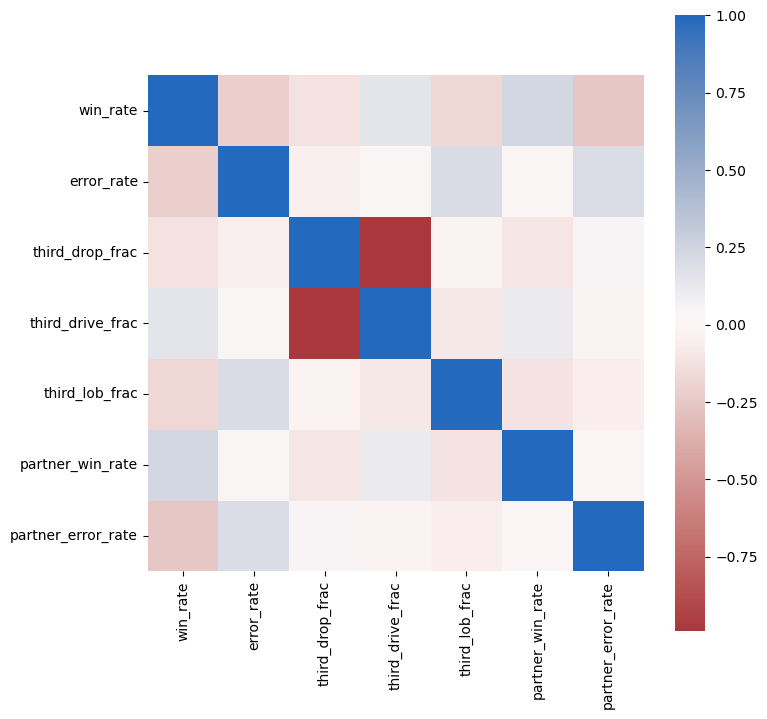

In [73]:
corr = summary_df.corr()
plt.subplots(figsize=(8, 8))
sns.heatmap(corr, cmap="vlag_r", square=True)
plt.savefig("../figures/correlations.png")
plt.show()

In [76]:
#Correlation between win rate and other stats
summary_df.corr().sort_values('win_rate', ascending=False)['win_rate']

win_rate              1.000000
partner_win_rate      0.234785
third_drive_frac      0.147398
third_drop_frac      -0.125079
third_lob_frac       -0.178006
error_rate           -0.214140
partner_error_rate   -0.256734
Name: win_rate, dtype: float64

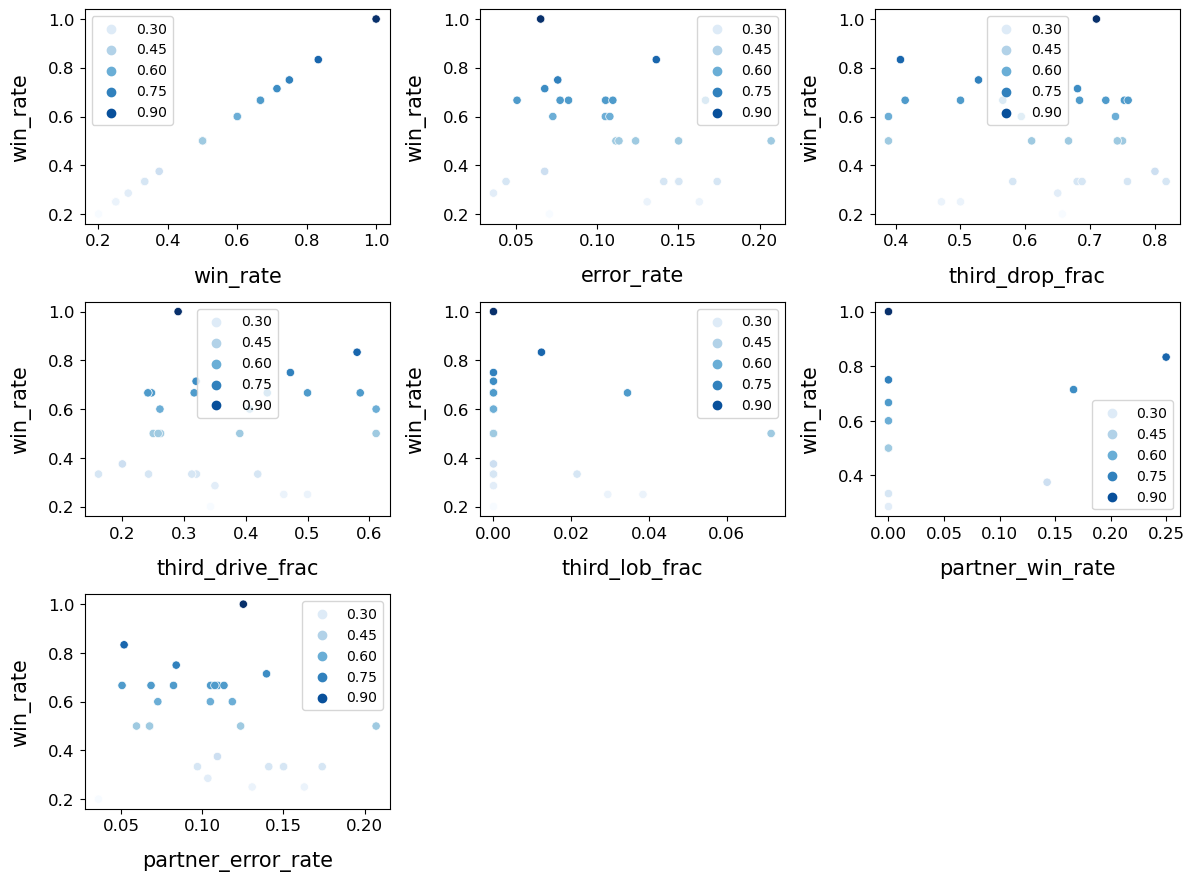

In [78]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in summary_df.columns:
    if summary_df[i].dtype in numeric_dtypes:
        if i in ['name']:
            pass
        else:
            numeric.append(i)    
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 20))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(summary_df[numeric]), 1):
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='win_rate', hue='win_rate', palette='Blues', data=summary_df)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('win_rate', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.tight_layout()
plt.show()

In [ ]:
#Todo: Add partner win rate